In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
from google.colab import files

In [3]:
from torchvision import transforms
from torch.utils import data
import torch.nn as nn
from tqdm import tqdm
import numpy as np

In [4]:
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [5]:
! kaggle datasets download -d gpiosenka/cards-image-datasetclassification
! unzip cards-image-datasetclassification.zip -d cards-image-datasetclassification

Streaming output truncated to the last 5000 lines.
  inflating: cards-image-datasetclassification/train/jack of spades/059.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/060.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/061.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/062.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/063.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/064.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/065.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/066.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/067.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/068.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/069.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/070.jpg  
  inflating: 

In [6]:
df = pd.read_csv('/content/cards-image-datasetclassification/cards.csv')
df.head()

,class index,filepaths,labels,card type,data set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train


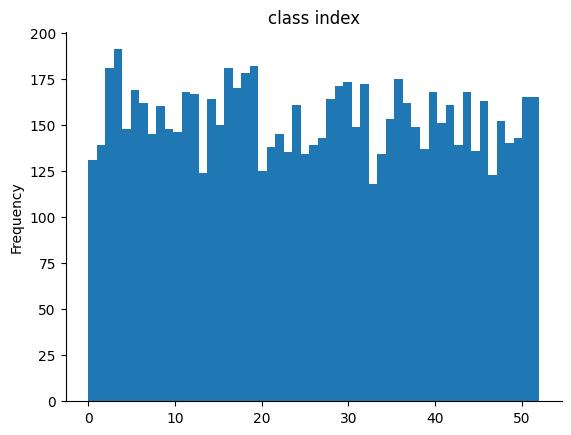

In [7]:
# @title class index

from matplotlib import pyplot as plt
df['class index'].plot(kind='hist', bins=53, title='class index')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [8]:
label_counts = df['labels'].value_counts().reset_index()
label_counts.columns = ['Label', 'Count']
print(label_counts)

                Label  Count
0       ace of spades    191
1      jack of spades    182
2       ace of hearts    181
3       jack of clubs    181
4      jack of hearts    178
5     seven of spades    175
6   queen of diamonds    173
7     queen of spades    172
8      queen of clubs    171
9    jack of diamonds    170
10  eight of diamonds    169
11     five of spades    168
12      ten of spades    168
13      six of spades    168
14      four of clubs    167
15      two of spades    165
16      two of hearts    165
17     four of hearts    164
18     nine of spades    164
19  three of diamonds    163
20    eight of hearts    162
21       six of clubs    162
22    ten of diamonds    161
23     king of spades    161
24      five of clubs    160
25    seven of hearts    153
26    three of spades    152
27       ten of clubs    151
28     four of spades    150
29    queen of hearts    149
30    six of diamonds    149
31   five of diamonds    148
32     eight of clubs    148
33     five of

In [9]:
rank_counts = df['card type'].value_counts().reset_index()
rank_counts.columns = ['Rank', 'Count']
print(rank_counts)

     Rank  Count
0    jack    711
1   queen    665
2     ace    642
3   eight    624
4    five    622
5     ten    619
6     six    616
7     two    613
8    four    605
9    nine    580
10  seven    580
11   king    579
12  three    574
13    xxx    125


In [10]:
df[df['data set'] == 'train'].shape, df[df['data set'] == 'valid'].shape, df[df['data set'] == 'test'].shape,

((7625, 5), (265, 5), (265, 5))

In [11]:
df['labels'].unique()

array(['ace of clubs', 'ace of diamonds', 'ace of hearts',
       'ace of spades', 'eight of clubs', 'eight of diamonds',
       'eight of hearts', 'eight of spades', 'five of clubs',
       'five of diamonds', 'five of hearts', 'five of spades',
       'four of clubs', 'four of diamonds', 'four of hearts',
       'four of spades', 'jack of clubs', 'jack of diamonds',
       'jack of hearts', 'jack of spades', 'joker', 'king of clubs',
       'king of diamonds', 'king of hearts', 'king of spades',
       'nine of clubs', 'nine of diamonds', 'nine of hearts',
       'nine of spades', 'queen of clubs', 'queen of diamonds',
       'queen of hearts', 'queen of spades', 'seven of clubs',
       'seven of diamonds', 'seven of hearts', 'seven of spades',
       'six of clubs', 'six of diamonds', 'six of hearts',
       'six of spades', 'ten of clubs', 'ten of diamonds',
       'ten of hearts', 'ten of spades', 'three of clubs',
       'three of diamonds', 'three of hearts', 'three of spades',

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Data Preparation
Augmenting the training images + creating our dataloaders

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.utils.data as data
import numpy as np
from tqdm import tqdm
import os
import time
import matplotlib.pyplot as plt

# These come from imagenet
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])


val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

train_dataset = datasets.ImageFolder('cards-image-datasetclassification/train', transform=train_transforms)
val_dataset = datasets.ImageFolder('cards-image-datasetclassification/valid', transform=val_test_transform)
test_dataset = datasets.ImageFolder('cards-image-datasetclassification/test', transform=val_test_transform)

train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)



torch.Size([224, 224, 3])


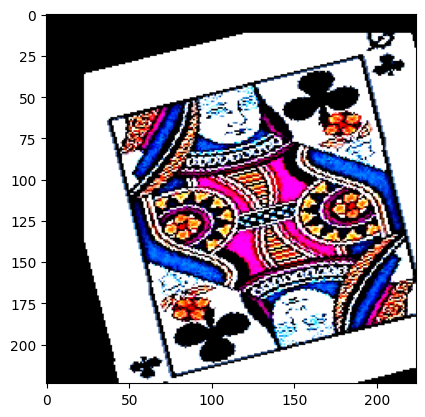

tensor(29)


In [37]:
import matplotlib.pyplot as plt


for image, label in train_loader:
  a, b = image[0], label[0]
  a = a.squeeze().permute(1, 2, 0)
  print(a.shape)
  plt.imshow(torch.squeeze(a, 0))
  plt.show()
  print(b)
  break

#Training function


In [22]:
def train(model, criterion, optimizer, train_loader, valid_loader, num_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} [Train]', leave=False)

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_postfix(loss=f'{loss.item():.4f}', acc=f'{(100 * correct_train / total_train):.2f}%')

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = 100 * correct_train / total_train

        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        progress_bar.close()

        # Validation
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        val_progress_bar = tqdm(valid_loader, desc=f'Epoch {epoch + 1}/{num_epochs} [Valid]', leave=False)

        with torch.no_grad():
            for inputs, labels in val_progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                val_progress_bar.set_postfix(loss=f'{loss.item():.4f}', acc=f'{(100 * correct_val / total_val):.2f}%')

        epoch_val_loss = running_val_loss / len(valid_loader.dataset)
        epoch_val_acc = 100 * correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        val_progress_bar.close()

        tqdm.write(f'\nEpoch {epoch + 1}/{num_epochs}:')
        tqdm.write(f'  Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}%')
        tqdm.write(f'  Valid Loss: {epoch_val_loss:.4f} | Valid Acc: {epoch_val_acc:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies




# Model initialization + training
## Pretrained model training

In [23]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.002
FINE_TUNE_EPOCHS = 5
FINE_TUNE_LR = 0.0005
num_classes = 53

# model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)


# Freezing all parameters from ResNet
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, num_classes)
)


model = model.to(device)
criterion = nn.CrossEntropyLoss()

params_to_update = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params_to_update, lr=LEARNING_RATE, weight_decay=0.00005)

history = {}
train_losses, val_losses, train_accuracies, val_accuracies = train(model, criterion, optimizer, train_loader, val_loader, NUM_EPOCHS)

history['train_loss'] = train_losses
history['val_loss'] = val_losses
history['train_acc'] = train_accuracies
history['val_acc'] = val_accuracies



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]



Epoch 1/10:
  Train Loss: 3.4514 | Train Acc: 12.91%
  Valid Loss: 2.4102 | Valid Acc: 25.66%



Epoch 2/10:
  Train Loss: 2.9381 | Train Acc: 21.55%
  Valid Loss: 2.1523 | Valid Acc: 33.21%



Epoch 3/10:
  Train Loss: 2.8738 | Train Acc: 22.32%
  Valid Loss: 2.1209 | Valid Acc: 34.34%



Epoch 4/10:
  Train Loss: 2.7823 | Train Acc: 25.00%
  Valid Loss: 2.0544 | Valid Acc: 31.70%



Epoch 5/10:
  Train Loss: 2.8352 | Train Acc: 24.15%
  Valid Loss: 1.9616 | Valid Acc: 33.58%



Epoch 6/10:
  Train Loss: 2.8200 | Train Acc: 25.64%
  Valid Loss: 1.8945 | Valid Acc: 34.72%



Epoch 7/10:
  Train Loss: 2.8003 | Train Acc: 25.70%
  Valid Loss: 1.9352 | Valid Acc: 40.00%



Epoch 8/10:
  Train Loss: 2.7778 | Train Acc: 26.60%
  Valid Loss: 1.8490 | Valid Acc: 42.64%



Epoch 9/10:
  Train Loss: 2.8016 | Train Acc: 26.25%
  Valid Loss: 1.9431 | Valid Acc: 39.25%



Epoch 10/10:
  Train Loss: 2.8356 | Train Acc: 26.06%
  Valid Loss: 2.0352 | Valid Acc: 39.62%


# Fine-tuning model

In [25]:
for param in model.layer4.parameters():
      param.requires_grad = True

for param in model.layer3.parameters():
    param.requires_grad = True


params_to_update = [p for p in model.parameters() if p.requires_grad]
optimizer_ft = optim.Adam(params_to_update, lr=FINE_TUNE_LR, weight_decay=0.00005)


train_losses_ft, val_losses_ft, train_accuracies_ft, val_accuracies_ft = train(model, criterion, optimizer_ft, train_loader, val_loader, FINE_TUNE_EPOCHS)

history['train_loss'].extend(train_losses_ft)
history['val_loss'].extend(val_losses_ft)
history['train_acc'].extend(train_accuracies_ft)
history['val_acc'].extend(val_accuracies_ft)


print('--- Training Complete ---')

# --- Evaluation on Test Set ---
def test_model(model):
  model.eval()
  correct_test = 0
  total_test = 0
  test_loss = 0.0

  test_progress_bar = tqdm(test_loader, desc='[Test]', leave=False)

  with torch.no_grad():
      for inputs, labels in test_progress_bar:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          loss = criterion(outputs, labels)

          test_loss += loss.item() * inputs.size(0)
          _, predicted = torch.max(outputs.data, 1)
          total_test += labels.size(0)
          correct_test += (predicted == labels).sum().item()
          test_progress_bar.set_postfix(acc=f'{(100 * correct_test / total_test):.2f}%')

  test_progress_bar.close()
  final_test_acc = 100 * correct_test / total_test
  final_test_loss = test_loss / len(test_loader.dataset)
  print(f'Test Loss: {final_test_loss:.4f}')
  print(f'Test Accuracy: {final_test_acc:.2f}%')

test_model(model)


Epoch 1/5:
  Train Loss: 1.9468 | Train Acc: 46.21%
  Valid Loss: 0.8533 | Valid Acc: 70.94%



Epoch 2/5:
  Train Loss: 1.1381 | Train Acc: 67.08%
  Valid Loss: 0.4252 | Valid Acc: 86.42%



Epoch 3/5:
  Train Loss: 0.9231 | Train Acc: 73.19%
  Valid Loss: 0.4043 | Valid Acc: 88.68%



Epoch 4/5:
  Train Loss: 0.7768 | Train Acc: 76.90%
  Valid Loss: 0.2768 | Valid Acc: 93.21%



Epoch 5/5:
  Train Loss: 0.6883 | Train Acc: 80.02%
  Valid Loss: 0.3265 | Valid Acc: 91.70%
--- Training Complete ---


Test Loss: 0.3549
Test Accuracy: 86.79%


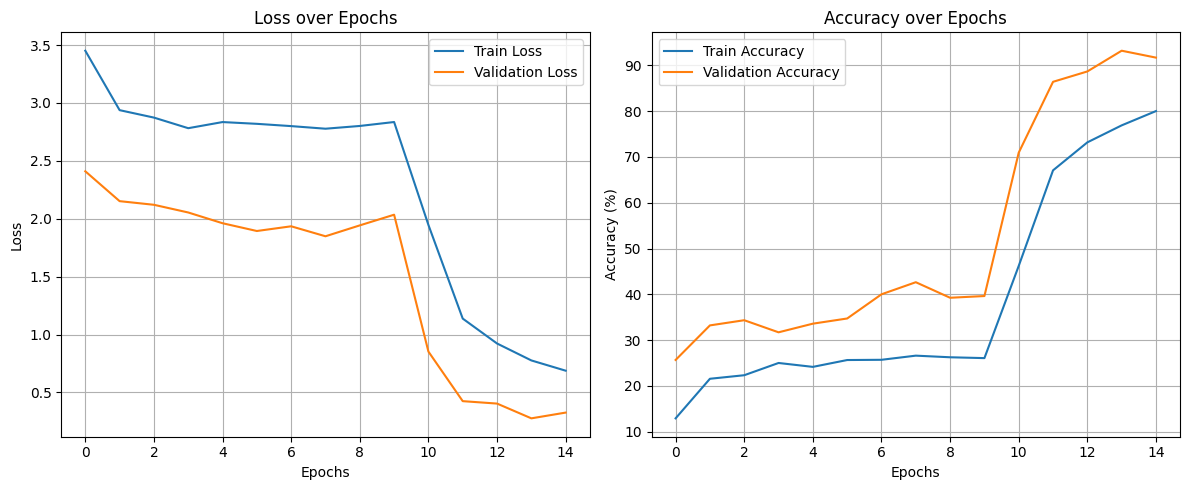

In [26]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
